In [1]:
import imp
import os

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly

from BuildingControlSimulator.Simulator.Simulation import Simulation
from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2


In [92]:
s = Simulation(
    building_model=EnergyPlusBuildingModel(
        idf=IDFPreprocessor(
            idf_name="SF+CZ2B+USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780+gasfurnace+crawlspace+IECC_2018.idf",
            init_temperature=21.),
        weather_name="USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780_TMY3.epw"
    ),
    controller=Deadband(deadband=2., stp_heat=21., stp_cool=24.),
    step_size_minutes=5,
    start_time_days = 204,
    final_time_days = 209,
)

2020-04-03 00:52:28 INFO     IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/SF+CZ2B+USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780+gasfurnace+crawlspace+IECC_2018.idf


In [93]:
%time s.initialize()

2020-04-03 00:52:29 INFO     Upgrading idf file. cur_version=8-6-0, target_version=8-9-0, transistion_path=/usr/local/EnergyPlus-8-9-0/PreProcess/IDFVersionUpdater/Transition-V8-6-0-to-V8-7-0
2020-04-03 00:52:33 INFO     Upgrading idf file. cur_version=8-7-0, target_version=8-9-0, transistion_path=/usr/local/EnergyPlus-8-9-0/PreProcess/IDFVersionUpdater/Transition-V8-7-0-to-V8-8-0
2020-04-03 00:52:38 INFO     Upgrading idf file. cur_version=8-8-0, target_version=8-9-0, transistion_path=/usr/local/EnergyPlus-8-9-0/PreProcess/IDFVersionUpdater/Transition-V8-8-0-to-V8-9-0
2020-04-03 00:52:43 INFO     Upgrading complete. Using: /root/home/lib/building-control-simulator/idf/v8-9-0/SF+CZ2B+USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780+gasfurnace+crawlspace+IECC_2018_8-9-0.idf
2020-04-03 00:52:43 INFO     Expanding objects. Using: /root/home/lib/building-control-simulator/idf/v8-9-0/SF+CZ2B+USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780+gasfurnace+crawlspace+IECC_2018_8-9-0.idf


CPU times: user 387 ms, sys: 92.2 ms, total: 480 ms
Wall time: 25.4 s


In [94]:
%time output_df = s.run()

CPU times: user 608 ms, sys: 88.9 ms, total: 697 ms
Wall time: 3.01 s


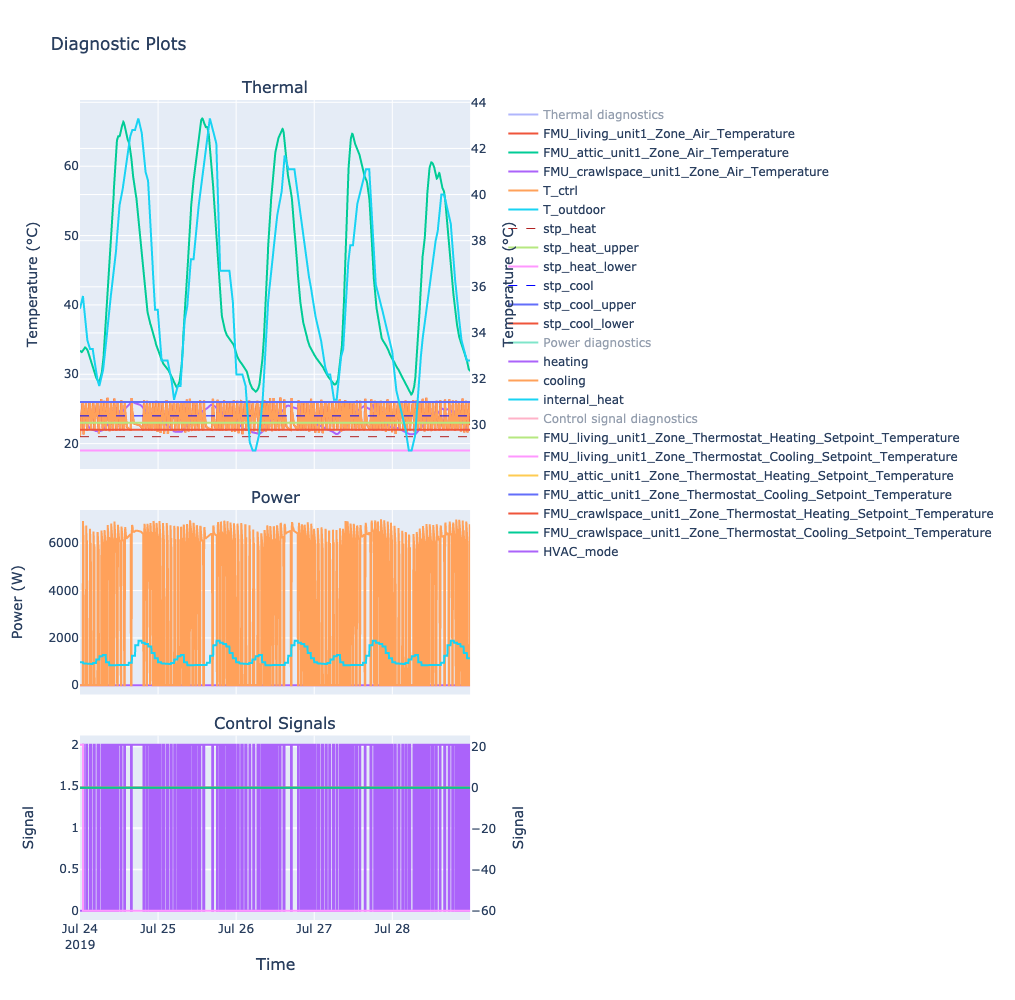

CPU times: user 1.73 s, sys: 9.78 ms, total: 1.74 s
Wall time: 1.75 s


In [95]:
%time s.show_plots()

In [ ]:
# 8000W cooling cap

# wall_consol_layer, !Name
#  Rough,!- Roughness
#  0.1889, !- Thickness {m}
#  0.0379573076923077, !- Conductivity {W/m-K}
#  120.801, !- Density {kg/m3}
#  1036.25775; !- Specific Heat {J/kg-K}

# ZoneInfiltration:EffectiveLeakageArea,
#     Living_ShermanGrimsrud_unit1,         !- Name
#     living_unit1,            !- Zone Name
#     always_avail,            !- Schedule Name
#     59.671216871124,                     !- Effective Air Leakage Area {cm2}
#     0.00029,                 !- Stack Coefficient
#     0.000231;                !- Wind Coefficient
output_df.total_cooling.sum()/12

In [103]:
# 9000W cooling cap

# wall_consol_layer, !Name
#  Rough,!- Roughness
#  0.1889, !- Thickness {m}
#  0.0379573076923077, !- Conductivity {W/m-K}
#  120.801, !- Density {kg/m3}
#  1036.25775; !- Specific Heat {J/kg-K}

# ZoneInfiltration:EffectiveLeakageArea,
#     Living_ShermanGrimsrud_unit1,         !- Name
#     living_unit1,            !- Zone Name
#     always_avail,            !- Schedule Name
#     59.671216871124,                     !- Effective Air Leakage Area {cm2}
#     0.00029,                 !- Stack Coefficient
#     0.000231;                !- Wind Coefficient
output_df.total_cooling.sum()

5108644.545879694

mean: 1831.4285714285713


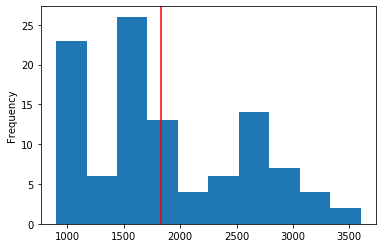

In [99]:
hvac_df = output_df[["time_seconds", "HVAC_mode"]].copy(deep=True)
hvac_df["HVAC_mode_prev"] = hvac_df.HVAC_mode.shift(periods=1)
hvac_mode_changes = hvac_df[hvac_df.HVAC_mode_prev != hvac_df.HVAC_mode].copy(deep=True)
hvac_mode_changes["time_seconds_prev"] = hvac_mode_changes.time_seconds.shift(periods=1)
hvac_mode_changes["time_delta"] = hvac_mode_changes["time_seconds"] - hvac_mode_changes["time_seconds_prev"]

off_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 2].time_delta
plt = off_cycles.plot.hist()
plt.axvline(x=off_cycles.mean(), color='r')
print("mean: {}".format(off_cycles.mean()))

total runtime (s): 239100.0
mean cycle length (s): 2299.0384615384614


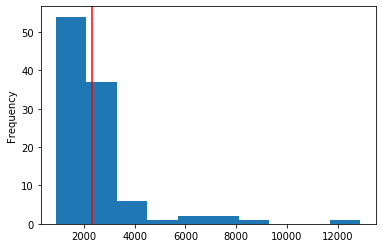

In [100]:
on_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 0].time_delta
plt = on_cycles.plot.hist()
plt.axvline(x=on_cycles.mean(), color='r')
print("total runtime (s): {}".format(on_cycles.sum()))
print("mean cycle length (s): {}".format(on_cycles.mean()))

In [6]:
# 9000W cooling cap
# wall_consol_layer, !Name
#  Rough,!- Roughness
#  0.1889, !- Thickness {m}
#  0.0379573076923077, !- Conductivity {W/m-K}
#  120.801, !- Density {kg/m3}
#  1036.25775; !- Specific Heat {J/kg-K}
output_df.total_cooling.sum()

6214064.917255911

In [9]:
# original, 9000W cooling cap
# wall_consol_layer, !Name
#  Rough,!- Roughness
#  0.0889, !- Thickness {m}
#  0.0379573076923077, !- Conductivity {W/m-K}
#  120.801, !- Density {kg/m3}
#  1036.25775; !- Specific Heat {J/kg-K}
output_df.total_cooling.sum()

6736379.067237222

In [46]:
# average cool-off cycle
hvac_mode_changes[hvac_mode_changes.HVAC_mode == 2].time_delta.mean()

1766.1971830985915

mean: 1766.1971830985915


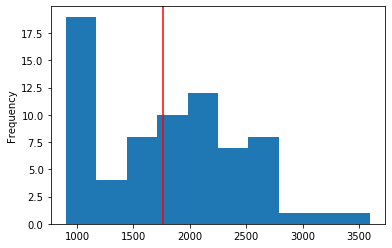

In [90]:
off_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 2].time_delta
plt = off_cycles.plot.hist()
plt.axvline(x=off_cycles.mean(), color='r')
print("mean: {}".format(off_cycles.mean()))

total runtime (s): 239100.0
mean cycle length (min): 38.31730769230769


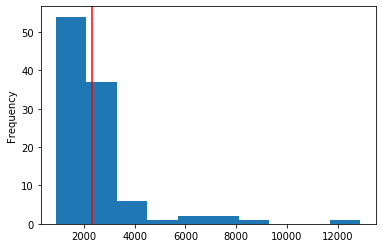

In [102]:
on_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 0].time_delta
plt = on_cycles.plot.hist()
plt.axvline(x=on_cycles.mean(), color='r')
print("total runtime (s): {}".format(on_cycles.sum()))
print("mean cycle length (min): {}".format(on_cycles.mean()/60.))

In [47]:
# average cool-on cycle
hvac_mode_changes[hvac_mode_changes.HVAC_mode == 0].time_delta.mean()

4375.714285714285